In [1]:
# import libararies
import tensorflow as tf
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding,Concatenate,GaussianNoise
from keras.engine.topology import Input
from keras.layers import MaxPooling1D,GlobalMaxPooling1D,Conv1D,Dense,Dropout,regularizers
from keras.models import Model,load_model
from keras import optimizers
import h5py # necessary for saving keras model
import numpy as np
import pickle
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt





/Applications/anaconda/envs/dlnd-tf-lab/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load word2vec embeddings

with open('w2v vectors.txt','rb') as f:
    embeddings = pickle.load(f)

In [7]:
embedding_dim = len(embeddings['man'])

In [9]:
vocab = list(embeddings.vocab.keys())

In [3]:
# load preprocessed data before vecortization
with open("Preprocessed data for CNN.txt",'rb') as f:
    texts_train_ls = pickle.load(f)
    texts_test_ls = pickle.load(f)
    labels_train = pickle.load(f)
    labels_test = pickle.load(f)
print (len(texts_train_ls))
print (len(texts_test_ls))
print (len(labels_train))
print (len(labels_test)) 

11314
7532
11314
7532


In [4]:
# build vocabulary of the text; elementary vectorization.
num_words = 20000
max_length = 300

tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts (texts_train_ls)
sequences_train = tokenizer.texts_to_sequences(texts_train_ls)
sequences_test = tokenizer.texts_to_sequences(texts_test_ls)

data_train = pad_sequences(sequences_train,maxlen = max_length)
data_test = pad_sequences(sequences_test,maxlen = max_length)

word_index = tokenizer.word_index
print (len(word_index.items()))

130787


In [5]:
targets_train = to_categorical(labels_train)
targets_test = to_categorical(labels_test)

In [10]:
# build embedding matrix
embedding_matrix = np.zeros((num_words+1,embedding_dim))

for word,index in word_index.items(): # word_index start with index one, not zero.
    if index > num_words:
        continue
    if word not in vocab:
        continue
    else:
        embedding_matrix[index] = embeddings[word]

In [11]:
# build embedding layer
embedding_layer = Embedding(num_words+1,embedding_dim,weights = [embedding_matrix],input_length = data_train.shape[1],trainable = False)

In [12]:
# vectorization
sequence_input = Input(shape = (data_train.shape[1],),dtype = 'int32')
embedded_input = embedding_layer(sequence_input)
model_pre = Model(sequence_input,embedded_input)

embedded_data_train = model_pre.predict(data_train)
embedded_data_test = model_pre.predict(data_test)

In [13]:
X_test_1 = embedded_data_test[:int(len(embedded_data_test)*0.4)]
X_test_2 = embedded_data_test[int(len(embedded_data_test)*0.4):]

y_test_1 = targets_test[:int(len(embedded_data_test)*0.4)]
y_test_2 = targets_test[int(len(embedded_data_test)*0.4):]

In [14]:
# split the original train set into a new train set and a validation set
X_train,X_val,y_train,y_val = train_test_split(embedded_data_train,targets_train,test_size = 0.2,random_state = 42)

In [15]:
with open("w2v_train_set_20000_300_TextCNN.txt",'wb') as f:
    pickle.dump(X_train,f)
    pickle.dump(X_val,f)
    pickle.dump(y_train,f)
    pickle.dump(y_val,f)

In [16]:
X_train.shape

(9051, 300, 100)

In [22]:
def draw_performance(history_list,n_epochs_per_hs):
# history_list: list of histories
# n_epochs_per_hs: the number of epochs per history

    hs_keys = list(history_list[0].history.keys())
    labels = hs_keys
    clr = ['r','orange','green','b']
    fig = plt.figure(figsize = (16,16))
    n_epochs = n_epochs_per_hs * len(history_list)

    for i in range(len(history_list)):
        for j,key in enumerate(hs_keys): 
            plt.plot(range(i*n_epochs_per_hs,(i+1)*n_epochs_per_hs),history_list[i].history[key],clr[j])
    plt.legend(labels)
    plt.grid(True,linestyle = "-",color = 'k',linewidth = 0.1)
    plt.xticks(np.arange(0,n_epochs,10))
    plt.yticks(np.arange(0,8,0.1))
    
    plt.show()

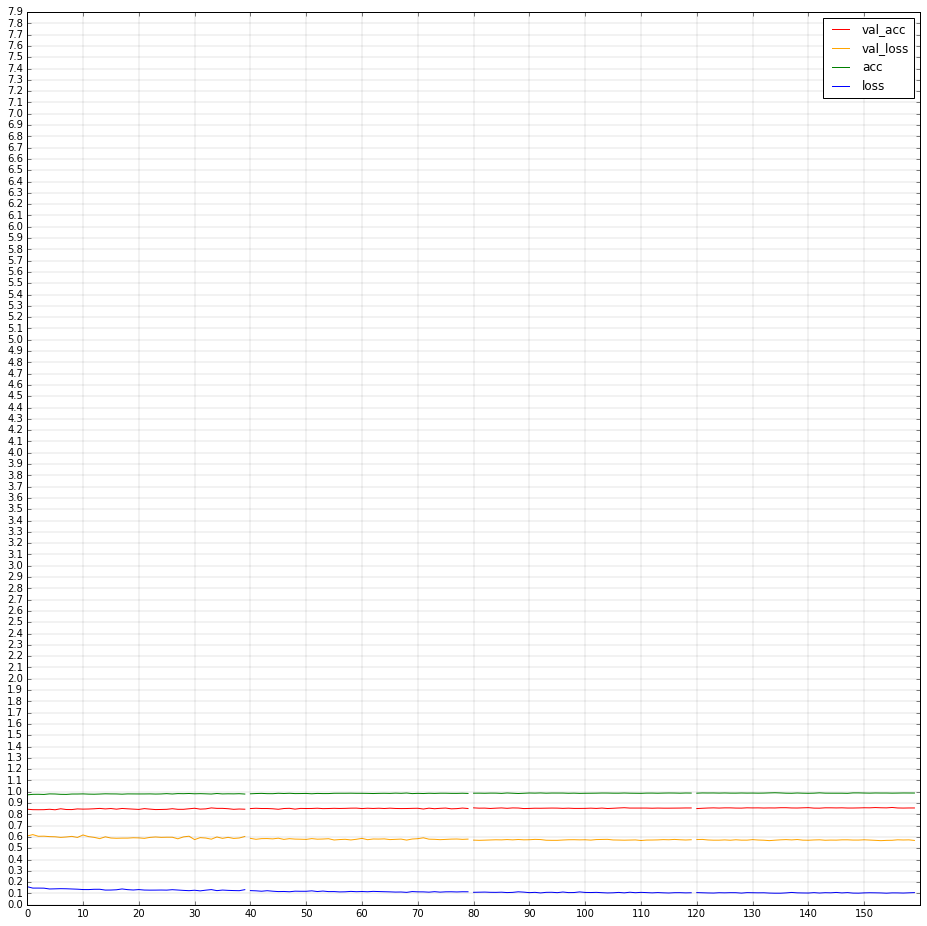

In [30]:
# the graph below shows performance of the 8th to 11th 40-epochs fitting
history_list = [hs_1_8,hs_1_9,hs_1_10,hs_1_11]#hs_1_1,hs_1_2,hs_1_3,hs_1_4,hs_1_5,hs_1_6,hs_1_7,
n_epochs_per_hs = 40

draw_performance(history_list,n_epochs_per_hs)

In [37]:
in_x = Input(shape = (X_train.shape[1],X_train.shape[2]),dtype = 'float32')

input_x = GaussianNoise(stddev = 0.01)(in_x)

x1 = Conv1D(128,3,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x1 = Dropout(0.5)(x1)

x2 = Conv1D(128,5,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x2 = Dropout(0.5)(x2)

x3 = Conv1D(128,7,activation = 'relu')(input_x)#,kernel_regularizer = regularizers.l2(0.01)
x3 = Dropout(0.5)(x3)

x1 = GlobalMaxPooling1D()(x1)# 128 dim vector
x2 = GlobalMaxPooling1D()(x2) # 128 dim vector
x3 = GlobalMaxPooling1D()(x3) # 128 dim vector


x = Concatenate(axis=-1)([x1,x2,x3])
x = Dropout(0.5)(x)

preds = Dense(y_train.shape[1], activation='softmax',kernel_regularizer = regularizers.l2(0.01))(x)#

model_1 = Model(in_x,preds)
optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_1.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])


hs_1_1 = model_1.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 69s 8ms/step - loss: 8.3931 - acc: 0.1266 - val_loss: 2.2257 - val_acc: 0.4238
Epoch 2/40
9051/9051 [==============================] - 68s 7ms/step - loss: 3.9564 - acc: 0.2854 - val_loss: 1.7937 - val_acc: 0.5736
Epoch 3/40
9051/9051 [==============================] - 68s 8ms/step - loss: 2.4042 - acc: 0.4163 - val_loss: 1.6265 - val_acc: 0.6270
Epoch 4/40
9051/9051 [==============================] - 68s 7ms/step - loss: 1.8063 - acc: 0.5170 - val_loss: 1.4842 - val_acc: 0.6845
Epoch 5/40
9051/9051 [==============================] - 67s 7ms/step - loss: 1.5438 - acc: 0.5806 - val_loss: 1.3874 - val_acc: 0.7030
Epoch 6/40
9051/9051 [==============================] - 68s 7ms/step - loss: 1.3591 - acc: 0.6225 - val_loss: 1.3138 - val_acc: 0.7176
Epoch 7/40
9051/9051 [==============================] - 67s 7ms/step - loss: 1.2132 - acc: 0.6621 - val_loss: 1.2334 - val_acc: 0.7371
Epoch 8

In [43]:
hs_1_2 = model_1.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.4896 - acc: 0.8907 - val_loss: 0.8027 - val_acc: 0.8259
Epoch 2/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.4781 - acc: 0.8964 - val_loss: 0.7939 - val_acc: 0.8197
Epoch 3/40
9051/9051 [==============================] - 68s 7ms/step - loss: 0.4869 - acc: 0.8922 - val_loss: 0.7992 - val_acc: 0.8179
Epoch 4/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.4863 - acc: 0.8933 - val_loss: 0.7878 - val_acc: 0.8210
Epoch 5/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.4726 - acc: 0.8995 - val_loss: 0.7763 - val_acc: 0.8250
Epoch 6/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.4642 - acc: 0.8988 - val_loss: 0.7953 - val_acc: 0.8153
Epoch 7/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.4572 - acc: 0.9014 - val_loss: 0.7750 - val_acc: 0.8237
Epoch 8

In [44]:
model_1.save("TextCNN-word2vec-model_1-2nd")

In [45]:
hs_1_3 = model_1.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.3410 - acc: 0.9296 - val_loss: 0.7207 - val_acc: 0.8299
Epoch 2/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.3459 - acc: 0.9293 - val_loss: 0.7085 - val_acc: 0.8294
Epoch 3/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.3365 - acc: 0.9357 - val_loss: 0.7149 - val_acc: 0.8316
Epoch 4/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.3371 - acc: 0.9327 - val_loss: 0.6925 - val_acc: 0.8414
Epoch 5/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.3328 - acc: 0.9357 - val_loss: 0.7146 - val_acc: 0.8299
Epoch 6/40
9051/9051 [==============================] - 68s 8ms/step - loss: 0.3347 - acc: 0.9322 - val_loss: 0.6969 - val_acc: 0.8440
Epoch 7/40
9051/9051 [==============================] - 68s 8ms/step - loss: 0.3300 - acc: 0.9339 - val_loss: 0.6983 - val_acc: 0.8449
Epoch 8

In [47]:
model_1.save("TextCNN-word2vec-model_1-3rd")

In [48]:
hs_1_4 = model_1.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.2766 - acc: 0.9469 - val_loss: 0.6689 - val_acc: 0.8414
Epoch 2/40
9051/9051 [==============================] - 71s 8ms/step - loss: 0.2791 - acc: 0.9442 - val_loss: 0.6715 - val_acc: 0.8418
Epoch 3/40
9051/9051 [==============================] - 71s 8ms/step - loss: 0.2803 - acc: 0.9473 - val_loss: 0.6781 - val_acc: 0.8356
Epoch 4/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.2785 - acc: 0.9474 - val_loss: 0.6775 - val_acc: 0.8316
Epoch 5/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.2672 - acc: 0.9528 - val_loss: 0.6707 - val_acc: 0.8374
Epoch 6/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.2758 - acc: 0.9482 - val_loss: 0.6778 - val_acc: 0.8387
Epoch 7/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.2729 - acc: 0.9488 - val_loss: 0.6601 - val_acc: 0.8422
Epoch 8

In [50]:
model_1.save("TextCNN-word2vec-model_1-4th")

In [51]:
hs_1_5 = model_1.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 73s 8ms/step - loss: 0.2420 - acc: 0.9560 - val_loss: 0.6626 - val_acc: 0.8285
Epoch 2/40
9051/9051 [==============================] - 74s 8ms/step - loss: 0.2342 - acc: 0.9574 - val_loss: 0.6414 - val_acc: 0.8392
Epoch 3/40
9051/9051 [==============================] - 71s 8ms/step - loss: 0.2317 - acc: 0.9589 - val_loss: 0.6402 - val_acc: 0.8352
Epoch 4/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.2327 - acc: 0.9609 - val_loss: 0.6642 - val_acc: 0.8347
Epoch 5/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.2356 - acc: 0.9572 - val_loss: 0.6508 - val_acc: 0.8338
Epoch 6/40
9051/9051 [==============================] - 72s 8ms/step - loss: 0.2294 - acc: 0.9597 - val_loss: 0.6447 - val_acc: 0.8427
Epoch 7/40
9051/9051 [==============================] - 68s 8ms/step - loss: 0.2276 - acc: 0.9572 - val_loss: 0.6582 - val_acc: 0.8374
Epoch 8

In [53]:
model_1.save("TextCNN-word2vec-model_1-5th")

In [54]:
hs_1_6 = model_1.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 68s 8ms/step - loss: 0.2150 - acc: 0.9629 - val_loss: 0.6619 - val_acc: 0.8303
Epoch 2/40
9051/9051 [==============================] - 68s 8ms/step - loss: 0.2148 - acc: 0.9620 - val_loss: 0.6667 - val_acc: 0.8202
Epoch 3/40
9051/9051 [==============================] - 68s 7ms/step - loss: 0.2228 - acc: 0.9601 - val_loss: 0.6447 - val_acc: 0.8352
Epoch 4/40
9051/9051 [==============================] - 68s 7ms/step - loss: 0.2104 - acc: 0.9613 - val_loss: 0.6456 - val_acc: 0.8325
Epoch 5/40
9051/9051 [==============================] - 68s 7ms/step - loss: 0.2115 - acc: 0.9619 - val_loss: 0.6367 - val_acc: 0.8418
Epoch 6/40
9051/9051 [==============================] - 68s 7ms/step - loss: 0.2117 - acc: 0.9623 - val_loss: 0.6270 - val_acc: 0.8467
Epoch 7/40
9051/9051 [==============================] - 68s 7ms/step - loss: 0.2086 - acc: 0.9617 - val_loss: 0.6460 - val_acc: 0.8356
Epoch 8

In [53]:
model_1.save("TextCNN-word2vec-model_1-5th")

In [56]:
hs_1_7 = model_1.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 68s 7ms/step - loss: 0.1977 - acc: 0.9645 - val_loss: 0.6621 - val_acc: 0.8361
Epoch 2/40
9051/9051 [==============================] - 68s 7ms/step - loss: 0.2034 - acc: 0.9653 - val_loss: 0.6577 - val_acc: 0.8356
Epoch 3/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.1949 - acc: 0.9676 - val_loss: 0.6386 - val_acc: 0.8374
Epoch 4/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.1965 - acc: 0.9659 - val_loss: 0.6441 - val_acc: 0.8387
Epoch 5/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.1854 - acc: 0.9711 - val_loss: 0.6222 - val_acc: 0.8484
Epoch 6/40
9051/9051 [==============================] - 67s 7ms/step - loss: 0.1887 - acc: 0.9680 - val_loss: 0.6493 - val_acc: 0.8392
Epoch 7/40
9051/9051 [==============================] - 67s 7ms/step - loss: 0.1969 - acc: 0.9635 - val_loss: 0.6345 - val_acc: 0.8431
Epoch 8

In [53]:
model_1.save("TextCNN-word2vec-model_1-6th")

In [58]:
hs_1_7 = model_1.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.1812 - acc: 0.9666 - val_loss: 0.6186 - val_acc: 0.8343
Epoch 2/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.1779 - acc: 0.9707 - val_loss: 0.6340 - val_acc: 0.8396
Epoch 3/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.1822 - acc: 0.9662 - val_loss: 0.6438 - val_acc: 0.8418
Epoch 4/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.1728 - acc: 0.9714 - val_loss: 0.6358 - val_acc: 0.8356
Epoch 5/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.1755 - acc: 0.9683 - val_loss: 0.6293 - val_acc: 0.8383
Epoch 6/40
9051/9051 [==============================] - 68s 8ms/step - loss: 0.1785 - acc: 0.9677 - val_loss: 0.6357 - val_acc: 0.8347
Epoch 7/40
9051/9051 [==============================] - 68s 7ms/step - loss: 0.1718 - acc: 0.9697 - val_loss: 0.6534 - val_acc: 0.8352
Epoch 8

In [59]:
model_1.save("TextCNN-word2vec-model_1-7th")

In [18]:
model_1 = load_model("TextCNN-word2vec-model_1-7th")

In [19]:
optimizer_8 = optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_1.compile(loss = 'categorical_crossentropy',optimizer=optimizer_8,metrics=['acc'])


hs_1_8 = model_1.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 68s 8ms/step - loss: 0.1602 - acc: 0.9729 - val_loss: 0.6089 - val_acc: 0.8458
Epoch 2/40
9051/9051 [==============================] - 68s 8ms/step - loss: 0.1478 - acc: 0.9775 - val_loss: 0.6211 - val_acc: 0.8418
Epoch 3/40
9051/9051 [==============================] - 71s 8ms/step - loss: 0.1479 - acc: 0.9780 - val_loss: 0.6063 - val_acc: 0.8414
Epoch 4/40
9051/9051 [==============================] - 71s 8ms/step - loss: 0.1472 - acc: 0.9765 - val_loss: 0.6073 - val_acc: 0.8418
Epoch 5/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.1400 - acc: 0.9814 - val_loss: 0.6033 - val_acc: 0.8453
Epoch 6/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.1413 - acc: 0.9804 - val_loss: 0.6019 - val_acc: 0.8409
Epoch 7/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.1427 - acc: 0.9776 - val_loss: 0.5965 - val_acc: 0.8498
Epoch 8

In [20]:
model_1.save("TextCNN-word2vec-model_1-8th")

In [21]:
optimizer_9 = optimizers.RMSprop(lr=0.00025, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_1.compile(loss = 'categorical_crossentropy',optimizer=optimizer_9,metrics=['acc'])

hs_1_9 = model_1.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 68s 7ms/step - loss: 0.1257 - acc: 0.9822 - val_loss: 0.5880 - val_acc: 0.8515
Epoch 2/40
9051/9051 [==============================] - 67s 7ms/step - loss: 0.1237 - acc: 0.9845 - val_loss: 0.5796 - val_acc: 0.8542
Epoch 3/40
9051/9051 [==============================] - 67s 7ms/step - loss: 0.1201 - acc: 0.9859 - val_loss: 0.5854 - val_acc: 0.8520
Epoch 4/40
9051/9051 [==============================] - 67s 7ms/step - loss: 0.1248 - acc: 0.9835 - val_loss: 0.5862 - val_acc: 0.8520
Epoch 5/40
9051/9051 [==============================] - 67s 7ms/step - loss: 0.1204 - acc: 0.9832 - val_loss: 0.5833 - val_acc: 0.8498
Epoch 6/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.1170 - acc: 0.9869 - val_loss: 0.5894 - val_acc: 0.8453
Epoch 7/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.1179 - acc: 0.9849 - val_loss: 0.5788 - val_acc: 0.8520
Epoch 8

In [24]:
model_1.save("TextCNN-word2vec-model_1-9th")

In [25]:
optimizer_10 = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None)#'rmsprop', decay=0.1
model_1.compile(loss = 'categorical_crossentropy',optimizer=optimizer_10,metrics=['acc'])

hs_1_10 = model_1.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 71s 8ms/step - loss: 0.1105 - acc: 0.9875 - val_loss: 0.5723 - val_acc: 0.8577
Epoch 2/40
9051/9051 [==============================] - 68s 7ms/step - loss: 0.1115 - acc: 0.9878 - val_loss: 0.5705 - val_acc: 0.8551
Epoch 3/40
9051/9051 [==============================] - 75s 8ms/step - loss: 0.1125 - acc: 0.9870 - val_loss: 0.5719 - val_acc: 0.8555
Epoch 4/40
9051/9051 [==============================] - 79s 9ms/step - loss: 0.1106 - acc: 0.9883 - val_loss: 0.5737 - val_acc: 0.8524
Epoch 5/40
9051/9051 [==============================] - 76s 8ms/step - loss: 0.1101 - acc: 0.9881 - val_loss: 0.5754 - val_acc: 0.8551
Epoch 6/40
9051/9051 [==============================] - 85s 9ms/step - loss: 0.1116 - acc: 0.9859 - val_loss: 0.5744 - val_acc: 0.8573
Epoch 7/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.1082 - acc: 0.9894 - val_loss: 0.5774 - val_acc: 0.8537
Epoch 8

In [28]:
model_1.save("TextCNN-word2vec-model_1-10th")

In [29]:
hs_1_11 = model_1.fit(X_train,y_train,batch_size = 128,epochs = 40,validation_data=(X_val, y_val))

Train on 9051 samples, validate on 2263 samples
Epoch 1/40
9051/9051 [==============================] - 68s 8ms/step - loss: 0.1079 - acc: 0.9877 - val_loss: 0.5773 - val_acc: 0.8515
Epoch 2/40
9051/9051 [==============================] - 70s 8ms/step - loss: 0.1064 - acc: 0.9897 - val_loss: 0.5785 - val_acc: 0.8542
Epoch 3/40
9051/9051 [==============================] - 72s 8ms/step - loss: 0.1049 - acc: 0.9892 - val_loss: 0.5737 - val_acc: 0.8564
Epoch 4/40
9051/9051 [==============================] - 68s 8ms/step - loss: 0.1040 - acc: 0.9895 - val_loss: 0.5717 - val_acc: 0.8577
Epoch 5/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.1069 - acc: 0.9883 - val_loss: 0.5718 - val_acc: 0.8559
Epoch 6/40
9051/9051 [==============================] - 71s 8ms/step - loss: 0.1059 - acc: 0.9895 - val_loss: 0.5743 - val_acc: 0.8577
Epoch 7/40
9051/9051 [==============================] - 69s 8ms/step - loss: 0.1073 - acc: 0.9882 - val_loss: 0.5713 - val_acc: 0.8577
Epoch 8

In [16]:
model_test = model_1
loss_1,acc_1 = model_test.evaluate(X_test_1,y_test_1)
loss_2,acc_2 = model_test.evaluate(X_test_2,y_test_2)
# weighted average of the two subsets for test
avg_acc = acc_1*0.4 + acc_2 *0.6
avg_loss = loss_1*0.4 + loss_2*0.6
print (loss_1,acc_1,loss_2,acc_2,avg_loss,avg_acc)

4520/4520 [==============================] - 8s 2ms/step
0.8960320547836552 0.7446879150066401 0.875202774790536 0.7553097345132743 0.8835344867877837 0.7510610067106207


In [17]:
# to calculate f1_score
from sklearn.metrics import f1_score
preds_1 = model_test.predict(X_test_1)
preds_2 = model_test.predict(X_test_2)
preds_1_s = [np.argmax(pred) for pred in preds_1]
preds_2_s = [np.argmax(pred) for pred in preds_2]
y_test_1_s = [np.argmax(y) for y in y_test_1]
y_test_2_s = [np.argmax(y) for y in y_test_2]
f1_1 = f1_score(y_test_1_s,preds_1_s,average = 'micro')
f1_2 = f1_score(y_test_2_s,preds_2_s,average = 'micro')
print (f1_1,f1_2)

0.74468791500664 0.7553097345132743
